# Import Libraries

In [ ]:
import os
import hashlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)

# Simple disk cache for downloaded data to avoid repeated network calls
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def _hash_params(tickers, start, end):
    tickers_key = ",".join(sorted(tickers))
    raw = f"{tickers_key}|{start}|{end}".encode()
    return hashlib.md5(raw).hexdigest()

def load_or_download_prices(tickers, start, end):
    cache_key = _hash_params(tickers, start, end)
    cache_path = os.path.join(CACHE_DIR, f"prices_{cache_key}.parquet")
    if os.path.exists(cache_path):
        return pd.read_parquet(cache_path)
    df = yf.download(tickers, start=start, end=end, progress=False)
    df.to_parquet(cache_path)
    return df

In [5]:
# Setting style for better plots 
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
# Define our stock tickers
tickers = ['AAPL', 'MSFT', 'META', 'GOOGL', 'SPY']

In [8]:
# Define our data range
start_date = '2020-01-01'
end_date = '2025-01-01'

print(f"Analysis Parameters:")
print(f"Tickers: {tickers}")
print(f"Date Range: {start_date} to {end_date}")


Analysis Parameters:
Tickers: ['AAPL', 'MSFT', 'META', 'GOOGL', 'SPY']
Date Range: 2020-01-01 to 2025-01-01


In [ ]:
# Step 1 - Collect Data
print("Downloading (or loading cached) stock data...")
data = load_or_download_prices(tickers, start=start_date, end=end_date)

In [13]:
print(f"Data shape: {data.shape}")
print(f"Date range in data: {data.index.min()} to {data.index.max()}")
print("\nFirst 5 rows of raw data:")
print(data.head())


Data shape: (1258, 25)
Date range in data: 2020-01-02 00:00:00 to 2024-12-31 00:00:00

First 5 rows of raw data:
Price           Close                                                 \
Ticker           AAPL      GOOGL        META        MSFT         SPY   
Date                                                                   
2020-01-02  72.538521  67.965225  208.635406  152.791107  299.406433   
2020-01-03  71.833305  67.609688  207.531448  150.888596  297.139313   
2020-01-06  72.405663  69.411766  211.440033  151.278641  298.272858   
2020-01-07  72.065155  69.277687  211.897507  149.899307  297.434143   
2020-01-08  73.224403  69.770782  214.045731  152.286972  299.019440   

Price            High                                                 ...  \
Ticker           AAPL      GOOGL        META        MSFT         SPY  ...   
Date                                                                  ...   
2020-01-02  72.598899  67.965225  208.645346  152.895746  299.424883  ...   
20

In [16]:
# Step 2 - Clean Data 
# Extract Close prices and flatten multi-level DataFrame
if len(tickers) > 1:
    close_prices = data['Close'].copy()
else:
    close_prices = data[['Close']].copy()
    close_prices.columns = tickers

# Handle missing values
print(f"Missing values before cleaning:")
print(close_prices.isnull().sum())

Missing values before cleaning:
Ticker
AAPL     0
GOOGL    0
META     0
MSFT     0
SPY      0
dtype: int64


In [21]:
print(f"\nFinal dataset shape: {close_prices.shape}")
print("\nCleaned Close Prices (first 5 rows):")
print(close_prices.head())


Final dataset shape: (1258, 5)

Cleaned Close Prices (first 5 rows):
Ticker           AAPL      GOOGL        META        MSFT         SPY
Date                                                                
2020-01-02  72.538521  67.965225  208.635406  152.791107  299.406433
2020-01-03  71.833305  67.609688  207.531448  150.888596  297.139313
2020-01-06  72.405663  69.411766  211.440033  151.278641  298.272858
2020-01-07  72.065155  69.277687  211.897507  149.899307  297.434143
2020-01-08  73.224403  69.770782  214.045731  152.286972  299.019440


In [20]:
# Step 3A - Calculate Daily Returns
# Calculate daily returns
returns = close_prices.pct_change().dropna()

print("Daily Returns Statistics:")
print(returns.describe())

Daily Returns Statistics:
Ticker         AAPL        GOOGL         META         MSFT          SPY
count   1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean       0.001182     0.001022     0.001225     0.000988     0.000618
std        0.019956     0.020472     0.028284     0.019211     0.013227
min       -0.128647    -0.116341    -0.263901    -0.147390    -0.109423
25%       -0.008425    -0.009533    -0.011625    -0.008176    -0.005150
50%        0.001187     0.001840     0.000996     0.001111     0.000900
75%        0.011989     0.011388     0.014495     0.010940     0.007292
max        0.119808     0.102244     0.232824     0.142169     0.090603


In [23]:
# Step 3B - Calculate Volatility 
# Calculate rolling volatility (30 days)
volatility = returns.rolling(window=30).std() * np.sqrt(252)  # Annualized volatility

print("Average Annualized Volatility:")
volatility_summary = volatility.mean().sort_values(ascending=False)
print(volatility_summary)



Average Annualized Volatility:
Ticker
META     0.415154
GOOGL    0.309312
AAPL     0.290789
MSFT     0.279414
SPY      0.178815
dtype: float64


In [25]:
# Step 3C - Calculate Correlations
# Calculate correlation matrix
correlation_matrix = returns.corr()

print("Correlation Matrix:")
print(correlation_matrix.round(3))

Correlation Matrix:
Ticker   AAPL  GOOGL   META   MSFT    SPY
Ticker                                   
AAPL    1.000  0.649  0.563  0.748  0.791
GOOGL   0.649  1.000  0.641  0.746  0.745
META    0.563  0.641  1.000  0.620  0.621
MSFT    0.748  0.746  0.620  1.000  0.819
SPY     0.791  0.745  0.621  0.819  1.000


In [26]:
# Step 3D - Calculate Moving Averages
# Calculate moving averages
ma_30 = close_prices.rolling(window=30).mean()
ma_90 = close_prices.rolling(window=90).mean()

print("Moving averages calculated successfully!")


Moving averages calculated successfully!


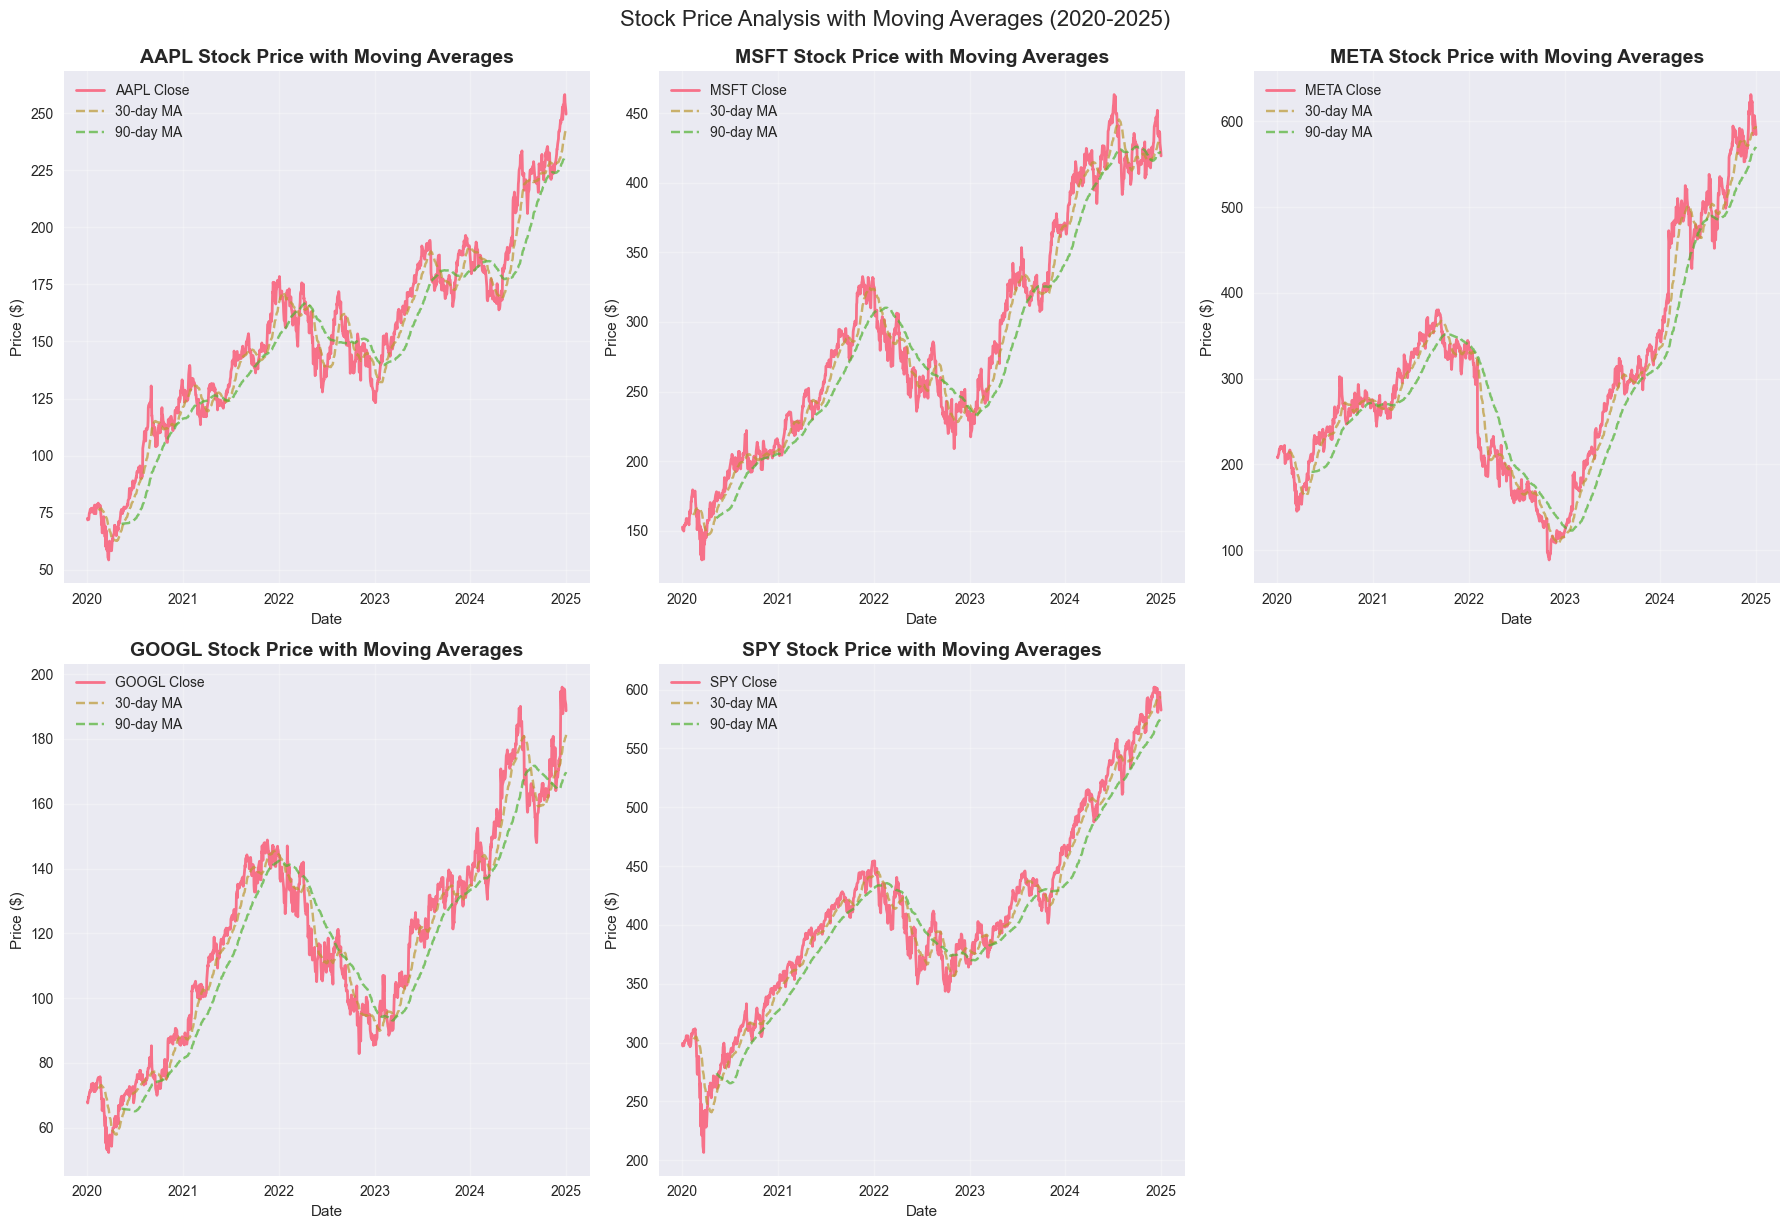

In [27]:
# Step 4A - Visualize Close Prices Over Time
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, ticker in enumerate(tickers):
    axes[i].plot(close_prices.index, close_prices[ticker], linewidth=2, label=f'{ticker} Close')
    axes[i].plot(ma_30.index, ma_30[ticker], '--', alpha=0.7, label='30-day MA')
    axes[i].plot(ma_90.index, ma_90[ticker], '--', alpha=0.7, label='90-day MA')
    axes[i].set_title(f'{ticker} Stock Price with Moving Averages', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price ($)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Remove the empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Stock Price Analysis with Moving Averages (2020-2025)', fontsize=16, y=1.02)
plt.show()

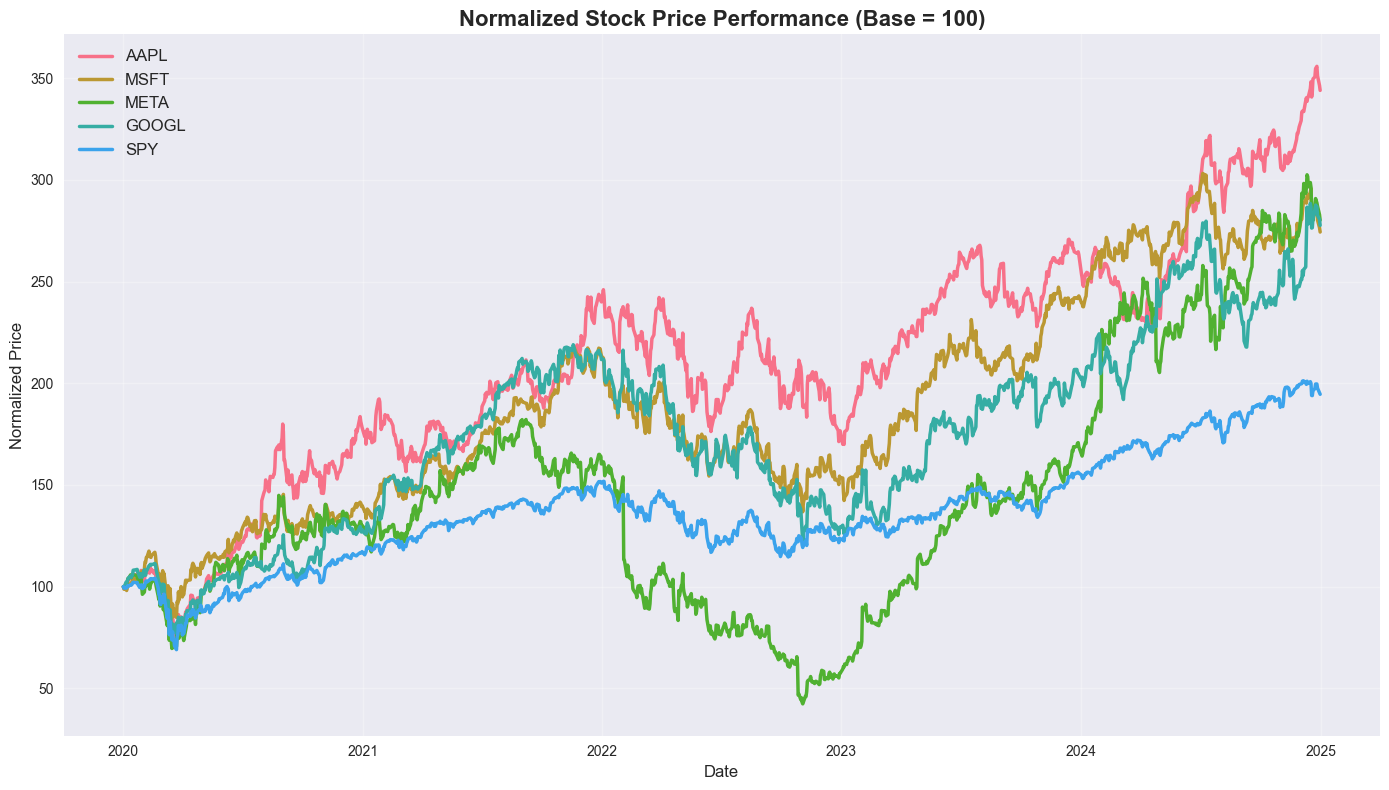

In [28]:
# Step 4B - Visualize All Stocks Together (Normalized)
# Normalize prices to start at 100 for comparison
normalized_prices = (close_prices / close_prices.iloc[0]) * 100

plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(normalized_prices.index, normalized_prices[ticker], linewidth=2.5, label=ticker)

plt.title('Normalized Stock Price Performance (Base = 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


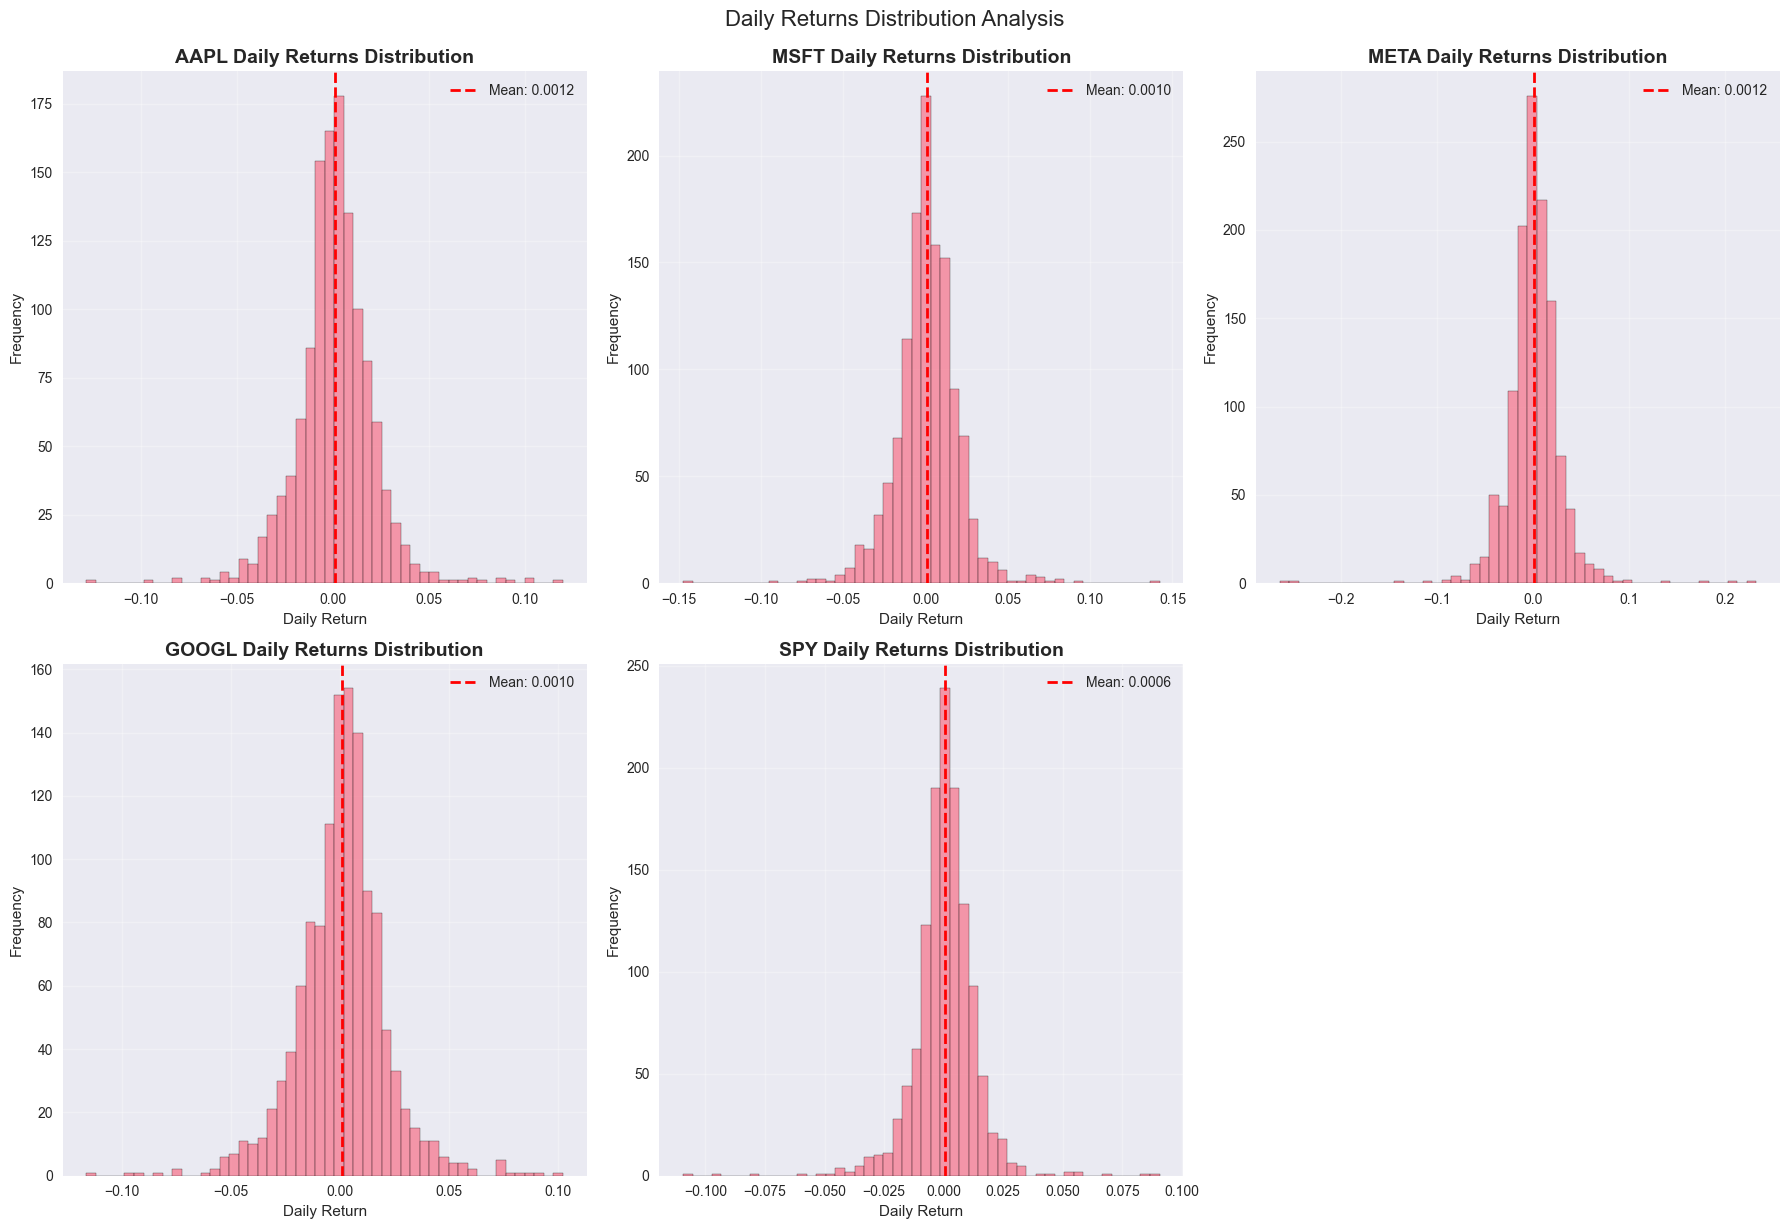

In [29]:
# Step 4C - Daily Returns Distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, ticker in enumerate(tickers):
    axes[i].hist(returns[ticker].dropna(), bins=50, alpha=0.7, edgecolor='black')
    axes[i].axvline(returns[ticker].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns[ticker].mean():.4f}')
    axes[i].set_title(f'{ticker} Daily Returns Distribution', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Daily Return')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Remove the empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Daily Returns Distribution Analysis', fontsize=16, y=1.02)
plt.show()

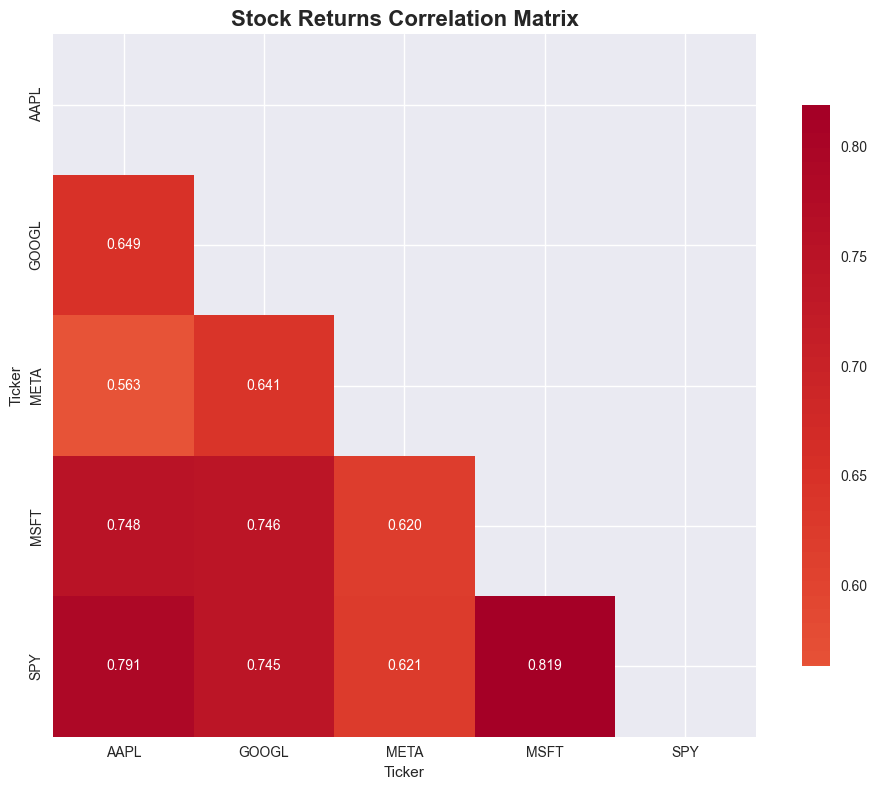

In [30]:
# Step 4D - Correlation Heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, 
                     mask=mask,
                     annot=True, 
                     cmap='RdYlBu_r', 
                     center=0,
                     square=True,
                     fmt='.3f',
                     cbar_kws={"shrink": .8})

plt.title('Stock Returns Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


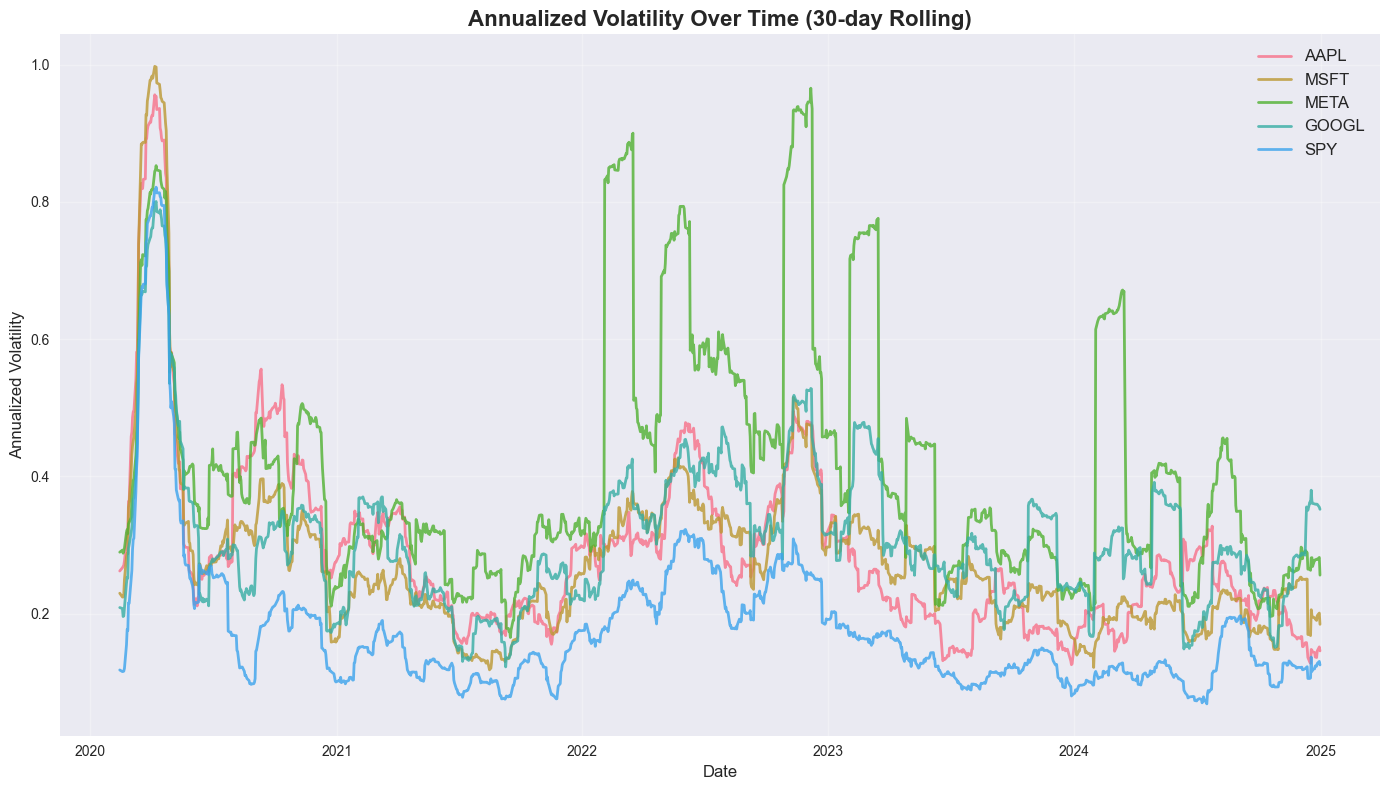

In [31]:
# Step 4E - Volatility Over Time
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(volatility.index, volatility[ticker], linewidth=2, label=f'{ticker}', alpha=0.8)

plt.title('Annualized Volatility Over Time (30-day Rolling)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annualized Volatility', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

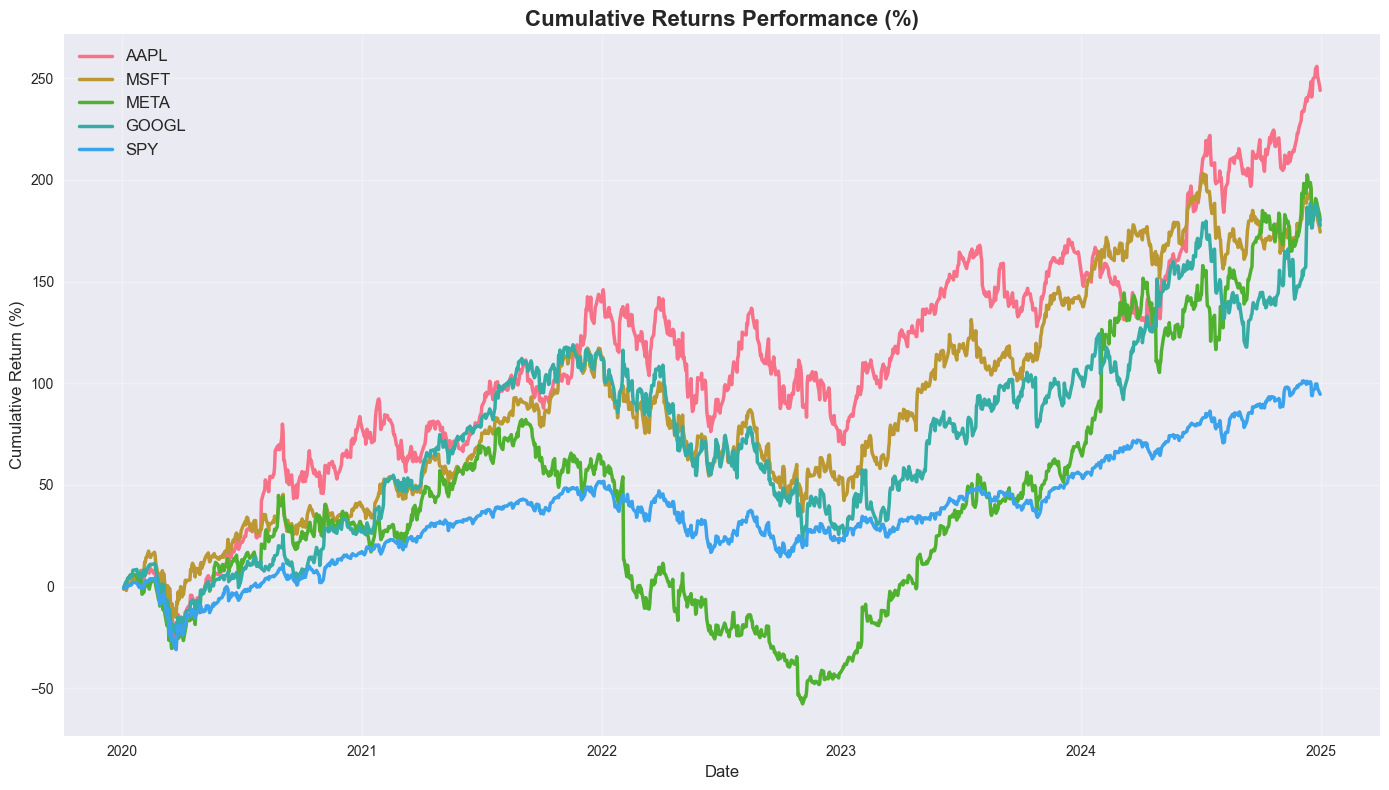

In [33]:
# Calculate Cumulative Returns
cumulative_returns = (1 + returns).cumprod() - 1

plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker] * 100, linewidth=2.5, label=ticker)

plt.title('Cumulative Returns Performance (%)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

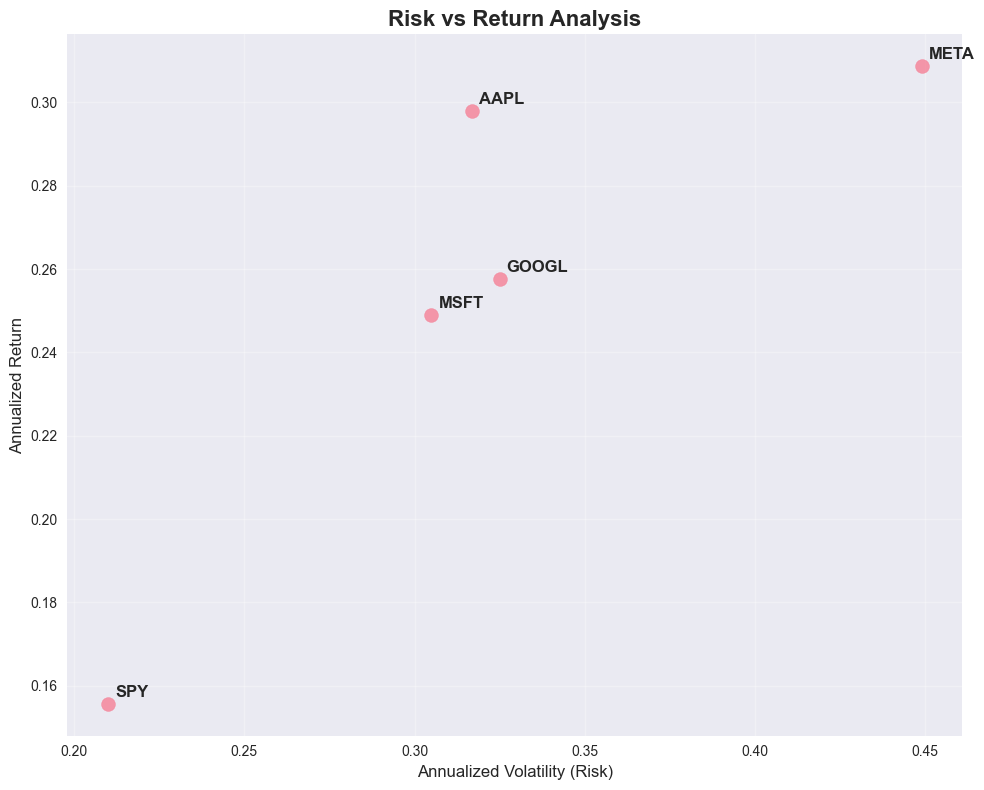

In [34]:
# Risk vs Return Analysis
mean_returns = returns.mean() * 252  # Annualized
annual_volatility = returns.std() * np.sqrt(252)  # Annualized

plt.figure(figsize=(10, 8))
scatter = plt.scatter(annual_volatility, mean_returns, s=100, alpha=0.7)

for i, ticker in enumerate(tickers):
    plt.annotate(ticker, (annual_volatility[ticker], mean_returns[ticker]), 
                xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.title('Risk vs Return Analysis', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
# Step 5 - Summary Statistics and Findings
print("="*80)
print("STOCK ANALYSIS SUMMARY (2020-2025)")
print("="*80)

# Performance metrics
total_return = ((close_prices.iloc[-1] / close_prices.iloc[0]) - 1) * 100
annual_return = mean_returns * 100
annual_vol = annual_volatility * 100
sharpe_ratio = mean_returns / returns.std()

summary_df = pd.DataFrame({
    'Total Return (%)': total_return,
    'Annual Return (%)': annual_return,
    'Annual Volatility (%)': annual_vol,
    'Sharpe Ratio': sharpe_ratio
}).round(2)

print("\nPERFORMANCE METRICS:")
print(summary_df.sort_values('Total Return (%)', ascending=False))

print(f"\nKEY FINDINGS:")
print(f"📈 Best Performer: {total_return.idxmax()} (+{total_return.max():.1f}%)")
print(f"📉 Worst Performer: {total_return.idxmin()} (+{total_return.min():.1f}%)")
print(f"⚡ Most Volatile: {annual_vol.idxmax()} ({annual_vol.max():.1f}%)")
print(f"🛡️ Least Volatile: {annual_vol.idxmin()} ({annual_vol.min():.1f}%)")
print(f"⭐ Best Risk-Adjusted Return: {sharpe_ratio.idxmax()} (Sharpe: {sharpe_ratio.max():.2f})")

# Correlation insights
high_corr_pairs = []
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        corr_val = correlation_matrix.iloc[i, j]
        if corr_val > 0.7:
            high_corr_pairs.append((tickers[i], tickers[j], corr_val))

print(f"\n🔗 HIGHLY CORRELATED PAIRS (>0.7):")
for pair in high_corr_pairs:
    print(f"   {pair[0]} - {pair[1]}: {pair[2]:.3f}")


STOCK ANALYSIS SUMMARY (2020-2025)

PERFORMANCE METRICS:
        Total Return (%)  Annual Return (%)  Annual Volatility (%)  \
Ticker                                                               
AAPL              244.00              29.79                  31.68   
META              180.17              30.87                  44.90   
GOOGL             177.62              25.76                  32.50   
MSFT              174.36              24.89                  30.50   
SPY                94.58              15.56                  21.00   

        Sharpe Ratio  
Ticker                
AAPL           14.93  
META           10.91  
GOOGL          12.58  
MSFT           12.96  
SPY            11.77  

KEY FINDINGS:
📈 Best Performer: AAPL (+244.0%)
📉 Worst Performer: SPY (+94.6%)
⚡ Most Volatile: META (44.9%)
🛡️ Least Volatile: SPY (21.0%)
⭐ Best Risk-Adjusted Return: AAPL (Sharpe: 14.93)

🔗 HIGHLY CORRELATED PAIRS (>0.7):
   AAPL - GOOGL: 0.748
   AAPL - SPY: 0.791
   MSFT - GOOGL: 0.74

In [36]:
# Pre/Post COVID Analysis
covid_start = '2020-03-01'  # Around when markets crashed
covid_recovery = '2021-01-01'  # Post-vaccine announcement recovery

pre_covid = close_prices.loc[start_date:covid_start]
covid_period = close_prices.loc[covid_start:covid_recovery]
post_covid = close_prices.loc[covid_recovery:]

print("\n" + "="*50)
print("COVID-19 IMPACT ANALYSIS")
print("="*50)

# Calculate returns for each period
pre_covid_returns = (pre_covid.iloc[-1] / pre_covid.iloc[0] - 1) * 100
covid_returns = (covid_period.iloc[-1] / covid_period.iloc[0] - 1) * 100
post_covid_returns = (post_covid.iloc[-1] / post_covid.iloc[0] - 1) * 100

covid_analysis = pd.DataFrame({
    'Pre-COVID (%)': pre_covid_returns,
    'COVID Period (%)': covid_returns,
    'Post-COVID (%)': post_covid_returns
}).round(1)

print("\nPERIOD-WISE RETURNS:")
print(covid_analysis)


COVID-19 IMPACT ANALYSIS

PERIOD-WISE RETURNS:
        Pre-COVID (%)  COVID Period (%)  Post-COVID (%)
Ticker                                                 
AAPL             -8.8              78.7            97.9
GOOGL            -2.2              26.4           120.1
META             -8.3              39.1           118.5
MSFT              1.1              29.7           100.3
SPY              -8.8              23.2            68.3


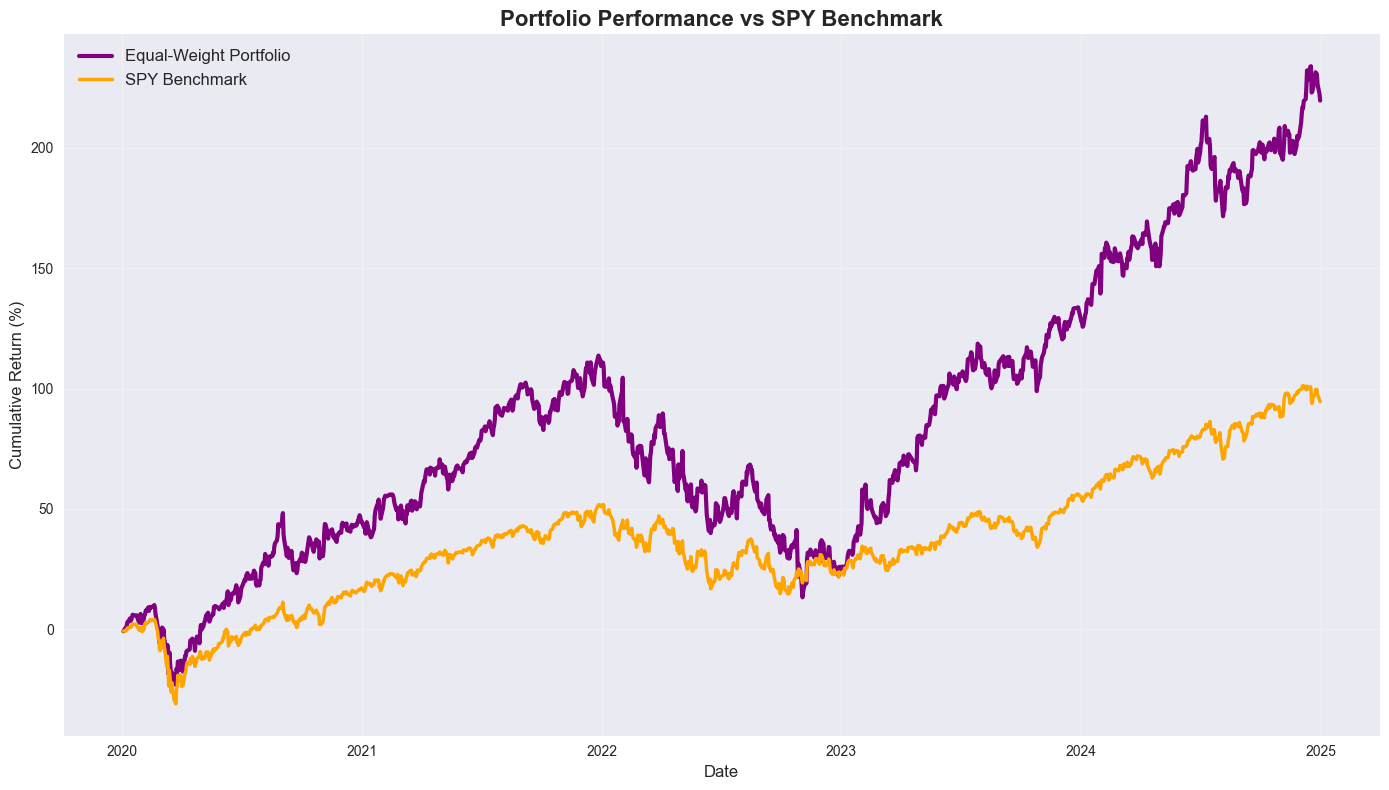


PORTFOLIO vs SPY COMPARISON:
Portfolio Annual Return: 27.8%
SPY Annual Return: 15.6%
Portfolio Volatility: 30.0%
SPY Volatility: 21.0%
Portfolio Sharpe Ratio: 0.06
SPY Sharpe Ratio: 11.77


In [37]:
# Create a Simple Portfolio
# Equal-weighted portfolio (excluding SPY for comparison)
portfolio_stocks = [ticker for ticker in tickers if ticker != 'SPY']
weights = np.array([1/len(portfolio_stocks)] * len(portfolio_stocks))

# Calculate portfolio returns
portfolio_returns = (returns[portfolio_stocks] * weights).sum(axis=1)
portfolio_cumulative = (1 + portfolio_returns).cumprod() - 1

plt.figure(figsize=(14, 8))
plt.plot(portfolio_cumulative.index, portfolio_cumulative * 100, linewidth=3, label='Equal-Weight Portfolio', color='purple')
plt.plot(cumulative_returns.index, cumulative_returns['SPY'] * 100, linewidth=2.5, label='SPY Benchmark', color='orange')

plt.title('Portfolio Performance vs SPY Benchmark', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Portfolio metrics
portfolio_annual_return = portfolio_returns.mean() * 252 * 100
portfolio_volatility = portfolio_returns.std() * np.sqrt(252) * 100
portfolio_sharpe = portfolio_returns.mean() / portfolio_returns.std()

print(f"\nPORTFOLIO vs SPY COMPARISON:")
print(f"Portfolio Annual Return: {portfolio_annual_return:.1f}%")
print(f"SPY Annual Return: {annual_return['SPY']:.1f}%")
print(f"Portfolio Volatility: {portfolio_volatility:.1f}%")
print(f"SPY Volatility: {annual_vol['SPY']:.1f}%")
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")
print(f"SPY Sharpe Ratio: {sharpe_ratio['SPY']:.2f}")



In [38]:
# Final Summary and Conclusions
print("\n" + "="*80)
print("INVESTMENT INSIGHTS & CONCLUSIONS")
print("="*80)

print(f"""
📊 ANALYSIS SUMMARY:
• Analyzed {len(tickers)} securities over {len(close_prices)} trading days
• Period: {start_date} to {end_date}
• Data source: Yahoo Finance via yfinance

🏆 TOP PERFORMERS:
• Best Total Return: {total_return.idxmax()} (+{total_return.max():.1f}%)
• Best Risk-Adjusted: {sharpe_ratio.idxmax()} (Sharpe: {sharpe_ratio.max():.2f})

⚖️ RISK ANALYSIS:
• Most Volatile: {annual_vol.idxmax()} ({annual_vol.max():.1f}% annual volatility)
• Least Volatile: {annual_vol.idxmin()} ({annual_vol.min():.1f}% annual volatility)

🔗 DIVERSIFICATION INSIGHTS:
• Tech stocks (AAPL, MSFT, META, GOOGL) show high correlation
• SPY provides good diversification as a broad market index
• Consider sector diversification for risk reduction

💡 INVESTMENT RECOMMENDATIONS:
• Growth investors: Focus on {total_return.nlargest(2).index.tolist()}
• Conservative investors: Consider {annual_vol.nsmallest(2).index.tolist()}
• Balanced approach: Equal-weight portfolio with regular rebalancing

⚠️ DISCLAIMERS:
• Past performance doesn't guarantee future results
• This analysis is for educational purposes only
• Always consult with financial advisors before investing
• Consider transaction costs, taxes, and market conditions
""")


INVESTMENT INSIGHTS & CONCLUSIONS

📊 ANALYSIS SUMMARY:
• Analyzed 5 securities over 1258 trading days
• Period: 2020-01-01 to 2025-01-01
• Data source: Yahoo Finance via yfinance

🏆 TOP PERFORMERS:
• Best Total Return: AAPL (+244.0%)
• Best Risk-Adjusted: AAPL (Sharpe: 14.93)

⚖️ RISK ANALYSIS:
• Most Volatile: META (44.9% annual volatility)
• Least Volatile: SPY (21.0% annual volatility)

🔗 DIVERSIFICATION INSIGHTS:
• Tech stocks (AAPL, MSFT, META, GOOGL) show high correlation
• SPY provides good diversification as a broad market index
• Consider sector diversification for risk reduction

💡 INVESTMENT RECOMMENDATIONS:
• Growth investors: Focus on ['AAPL', 'META']
• Conservative investors: Consider ['SPY', 'MSFT']
• Balanced approach: Equal-weight portfolio with regular rebalancing

⚠️ DISCLAIMERS:
• Past performance doesn't guarantee future results
• This analysis is for educational purposes only
• Always consult with financial advisors before investing
• Consider transaction costs, 